# Datamining

In [2]:
SEED = 26062019

test_size = 0.5 

import sys
import numpy as np
import pandas as pd
from sklearn import __version__ as sk_vers
import matplotlib.pyplot as plt
from matplotlib import __version__ as m_vers
import pickle
import seaborn as sns
#numpy==1.15.4


print('Current versions Modules:\n')
print('Pandas version:\t\t' + pd.__version__)
print('Matplotlib version:\t' + m_vers)
print('numpy version:\t\t' + np.__version__)
print('sklearn version:\t' + sk_vers)

Current versions Modules:

Pandas version:		0.24.2
Matplotlib version:	3.1.0
numpy version:		1.15.4
sklearn version:	0.21.2


## Load data

In [5]:
df_mood = pd.read_csv(r'data/dataset_mood_smartphone.csv', sep=',', index_col=0)
print('nr of entries: ', len(df_mood))
df_mood['time'] = df_mood['time'].astype('datetime64[ns]')

df_mood.head()

nr of entries:  376912


,id,time,variable,value
1,AS14.01,2014-02-26 13:00:00,mood,6.0
2,AS14.01,2014-02-26 15:00:00,mood,6.0
3,AS14.01,2014-02-26 18:00:00,mood,6.0
4,AS14.01,2014-02-26 21:00:00,mood,7.0
5,AS14.01,2014-02-27 09:00:00,mood,6.0


(5641, 5643, 5643, 22965, 96578, 5239, 1798, 91288, 74276, 27125, 939, 813, 5642, 7650, 19145, 2846, 939, 2487, 255)


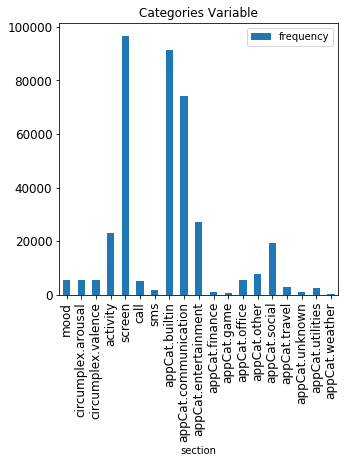

In [6]:
from collections import Counter

labels, values = zip(*Counter(df_mood['variable']).items())
print(values)
df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Categories Variable", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=90)

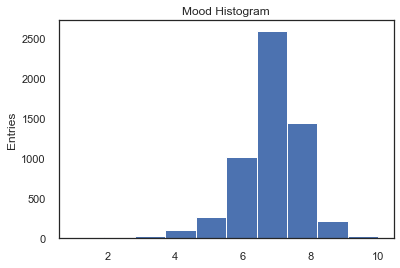

In [347]:
from collections import Counter

sub_mood = df_mood[df_mood['variable']=='mood']

x = sub_mood['value']
plt.hist(x)
plt.gca().set(title='Mood Histogram', ylabel='Entries');

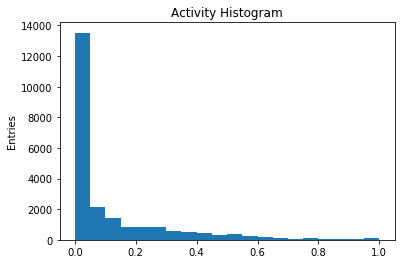

In [5]:
from collections import Counter

sub_mood = df_mood[df_mood['variable']=='activity']

x = sub_mood['value']
plt.hist(x, bins=20)
plt.gca().set(title='Activity Histogram', ylabel='Entries');

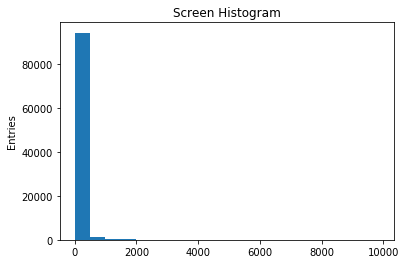

In [14]:
from collections import Counter

sub_mood = df_mood[df_mood['variable']=='screen']

x = sub_mood['value']
plt.hist(x, bins=20)
plt.gca().set(title='Screen Histogram', ylabel='Entries');

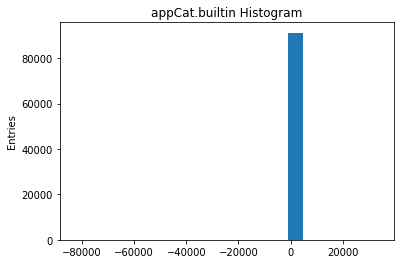

In [8]:
from collections import Counter

sub_mood = df_mood[df_mood['variable']=='appCat.builtin']

x = sub_mood['value']
plt.hist(x, bins=20)
plt.gca().set(title='appCat.builtin Histogram', ylabel='Entries');

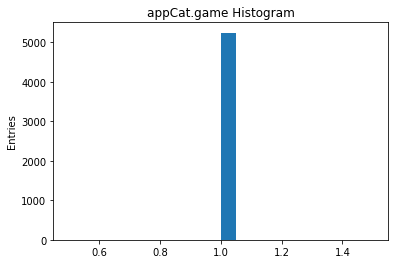

In [13]:
from collections import Counter

sub_mood = df_mood[df_mood['variable']=='call']

x = sub_mood['value']
plt.hist(x, bins=20)
plt.gca().set(title='appCat.game Histogram', ylabel='Entries');

## Aggregate Data

### step 1: Count days since inclusion
This is an important step to prepare the data for time window aggregation.

In [8]:
from pandas import datetime
class Aggregation(object):
    """
    Summary class:
        Aggregate the temporial data with a time window
        
        - key = id column, unique users
        - define the column with the timestamp
        - define the window size
    """
    def __init__(self, df, key, timestamp, window=5):
        self.df = df
        self.key = key
        self.window = window
        self.timestamp = timestamp
    
    def setDF(self):
        self.df = df
        
    def getDF(self):
        return self.df
    
    def parser(self, x):
        return datetime.strptime(str(x)[:10], '%Y-%m-%d')
    
    def formatTimeSpan(self):
        """
        Translate time stamps to time in days ever since inclusion of said user
        
        Translate informational absent single observation columns 
        to meaningful frequencies. (For example: sms & calls columns)
        
        """
        cols = list(self.df.keys())
        cols.append('days')
        df_new = pd.DataFrame(columns=cols)
        for subject in self.df[self.key].unique():
            df_sub = self.df[self.df[self.key]==subject]
            df_sub, initial_date = self.countTheDays(df_sub)
            for day in range(df_sub['days'].max()):
                df_day = df_sub[df_sub['days']==day]
                nr_calls = len(df_day[df_day['variable']=='call'])
                #print(nr_calls)
                if nr_calls != 0:
                    df_calls = pd.DataFrame([pd.Series([df_day['id'].iloc[0], self.parser(df_day['time'].iloc[0]), 'total_calls', nr_calls, day])])
                    df_calls = df_calls.rename(columns={0: cols[0], 1: cols[1], 2: cols[2], 3: cols[3], 4: cols[4]})
                    #print(df_calls)
                    
                    df_sub = pd.concat([df_sub, df_calls], axis=0)
                nr_sms = len(df_day[df_day['variable']=='sms'])
                if nr_sms != 0:
                    df_sms = pd.DataFrame([pd.Series([df_day['id'].iloc[0], df_day['time'].iloc[0], 'total_sms', nr_sms, day])])
                    df_sms = df_sms.rename(columns={0: cols[0], 1: cols[1], 2: cols[2], 3: cols[3], 4: cols[4]})
                    df_sub = pd.concat([df_sub, df_sms], axis=0)
                if day not in list(df_sub['days'].unique()):
                    #print(day)
                    date= self.parser(initial_date) + pd.Timedelta(days=day)
                    s = pd.DataFrame([pd.Series([df_sub['id'].iloc[0],date,'mood',np.nan, day], index=cols)])
                    df_sub = pd.concat([df_sub, s], axis=0, ignore_index=True)# df_sub.append(s, ignore_index=True)
            df_new = pd.concat([df_new, df_sub])
        self.df = df_new
        
    def countTheDays(self, df_sub):
        initial_date = df_sub[self.timestamp].min()
        df_sub['days'] = pd.to_datetime(df_sub[self.timestamp]).sub(initial_date).dt.days
        return df_sub, initial_date

    
def parser(x):
    #print(str(x)[:10])
    return datetime.strptime(str(x)[:10], '%Y-%m-%d')
    
df_mood['time'] = df_mood['time'].apply(lambda x : parser(x))
agg = Aggregation(df_mood, 'id', 'time', window=5)
agg.formatTimeSpan()
temp_df = agg.getDF()
temp_df.head()

C:\Users\levrex\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,id,time,variable,value,days
0,AS14.01,2014-02-26,mood,6.0,9
1,AS14.01,2014-02-26,mood,6.0,9
2,AS14.01,2014-02-26,mood,6.0,9
3,AS14.01,2014-02-26,mood,7.0,9
4,AS14.01,2014-02-27,mood,6.0,10


In [405]:
temp_df_unstack.head()

variable,id,days,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.other,appCat.social,appCat.travel,circumplex.arousal,circumplex.valence,mood,screen,total_calls,total_sms
0,AS14.01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
1,AS14.01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,AS14.01,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,2.0
3,AS14.01,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0
4,AS14.01,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


## Aggregate History

### Step 1: Transform long to wide
### Step 2: Aggregate 

In [408]:
class Aggregation2(object):
    """
    Summary class:
        Aggregate the temporial data with a time window
        
        - key = id column, unique users
        - define the column with the timestamp
        - define the window size
    """
    def __init__(self, df, key, timestamp, window=5):
        self.df = df
        self.key = key
        self.window = window
        self.timestamp = timestamp
        
    def getFinalMood(self, row):
        #print(row['days'])
        next_day = int(row['days']) + 1
        
        subject = row['id']
        if next_day < len(self.df[self.df[self.key]==subject]):
            next_mood = self.df[((self.df[self.key]==subject)&(self.df['days']==next_day))]['mood'].iloc[0]
            # print(next_mood)
        else :
            next_mood = np.nan
        return next_mood
    
    def aggregate(self, window_size):
        # create sub df for each subject
        cols = list(self.df.keys())
        #print(cols)
        cols.append('final_mood') # add label
        df_new = pd.DataFrame(columns=cols)
        for subject in self.df[self.key].unique():
            df_sub = self.df[self.df[self.key]==subject]
            df_sub.rolling(5).agg({'activity':'mean', 'appCat.builtin':'mean', 'appCat.communication':'mean','appCat.entertainment':'mean', 
                           'appCat.other':'mean','appCat.social':'mean', 'appCat.travel':'mean', 'circumplex.arousal':'mean',  
                           'circumplex.valence':'mean',  'mood':'mean',  'screen':'mean',  'total_calls':'mean',  'total_sms':'mean'})
            df_sub['final_mood'] = df_sub['days'].copy()
            #df_sub['time'] = df_sub['days'].copy()
            #print(df_sub)
            df_sub['final_mood'] = df_sub.apply(lambda x : self.getFinalMood(x), axis=1)
            df_sub['days'] = df_sub['days'].apply(lambda x : 'day '+ str(x-window_size+1)+ ' to ' + str(x+1))
            df_new = pd.concat([df_new, df_sub])
        self.df = df_new
        return
    
    def getDF(self):
        return self.df

temp_df_unstack = temp_df.groupby(['id', 'days','variable'])['value'].median().unstack('variable')
temp_df_unstack = temp_df_unstack[['activity', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.other', 'appCat.social', 'appCat.travel',
       'circumplex.arousal', 'circumplex.valence', 'mood', 'screen',
       'total_calls', 'total_sms']]
temp_df_unstack = temp_df_unstack.reset_index(drop=False)
temp_df_unstack.to_csv(r'data/prep_temporal_raw.csv', index = False, header=True)
agg = Aggregation2(temp_df_unstack, 'id', 'time', window=5)
agg.aggregate(5)
temp_df_2 = agg.getDF()
temp_df_2.head()

C:\Users\levrex\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\levrex\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\levrex\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

variable,id,days,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.other,appCat.social,appCat.travel,circumplex.arousal,circumplex.valence,mood,screen,total_calls,total_sms,final_mood
0,AS14.01,day -4 to 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
1,AS14.01,day -3 to 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2,AS14.01,day -2 to 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,2.0,NaN
3,AS14.01,day -1 to 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,NaN
4,AS14.01,day 0 to 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


## Write preprocessed aggregated datasets
Two versions:
- With missing mood values or labels () (raw)
- Without missing mood values or labels
Note: we also ensure that the current mood was registered otherwise we cant compare to baseline

In [99]:
print('Nr entries with available label:', len(temp_df_2[((~temp_df_2['final_mood'].isna()) & (~temp_df_2['mood'].isna()))]))
print('Nr of entries with missing label:', len(temp_df_2[((temp_df_2['final_mood'].isna()) | (temp_df_2['mood'].isna()))]))
temp_df_2.to_csv(r'data/prep_aggregated_raw.csv', index = False, header=True)
temp_df_2[((~temp_df_2['final_mood'].isna()) & (~temp_df_2['mood'].isna()))].to_csv(r'data/prep_aggregated_noNan.csv', index = False, header=True)

1232


In [ ]:
from collections import Counter

x = temp_df_2['final_mood']
plt.hist(x, bins=10)
plt.gca().set(title='finalMood', ylabel='Entries');

(1, 1, 5, 37, 217, 693, 259, 18, 1)


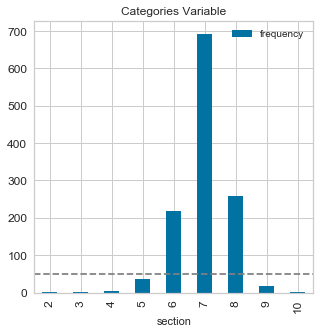

In [22]:
#df_agg[df_agg.columns[-1]].sum()
from collections import Counter

labels, values = zip(*Counter(df_agg[df_agg.columns[-1]]).items())
print(values)
df = pd.DataFrame({'section':[2,3,4,5,6,7,8,9,10], 'frequency':values})
ax = df.plot(kind='bar',  title ="Categories Variable", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=90)
ax.axhline(y=50, xmin=0, xmax=1, color='grey', linestyle='--')

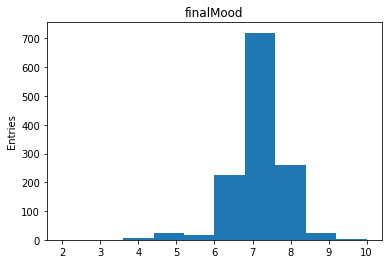

In [100]:
from collections import Counter

x = temp_df_2['final_mood']
plt.hist(x, bins=10)
plt.gca().set(title='finalMood', ylabel='Entries');

In [23]:
import pandas as pd
df_agg = pd.read_csv(r'data/prep_aggregated_noNan.csv', sep=',')
print('nr of entries: ', len(df_agg))
df_agg.head()

nr of entries:  1232


,id,days,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.other,appCat.social,appCat.travel,circumplex.arousal,circumplex.valence,mood,screen,total_calls,total_sms,final_mood
0,AS14.01,day 5 to 10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,0.5,6.0,NaN,1.0,2.0,7.0
1,AS14.01,day 27 to 32,0.008333,3.0410,27.6845,22.7870,13.6375,65.335,14.067,-0.5,0.0,6.0,31.748,NaN,NaN,7.0
2,AS14.01,day 28 to 33,0.144068,3.9040,24.6470,21.2360,10.1110,42.241,19.696,1.0,1.0,7.0,27.813,6.0,NaN,7.0
3,AS14.01,day 29 to 34,0.218487,4.0190,20.4580,46.6620,12.0540,40.275,NaN,0.0,1.0,7.0,17.975,3.0,1.0,6.0
4,AS14.01,day 30 to 35,0.055645,3.1085,19.8080,21.5865,9.0280,44.157,NaN,1.0,0.0,6.0,25.985,NaN,NaN,6.0


## missingness

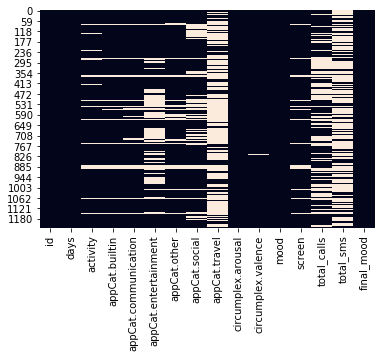

In [3]:
import seaborn as sns

heatmap = sns.heatmap(df_agg.isnull(), cbar=False)
heatmap.figure.savefig("figures/missingness.png")

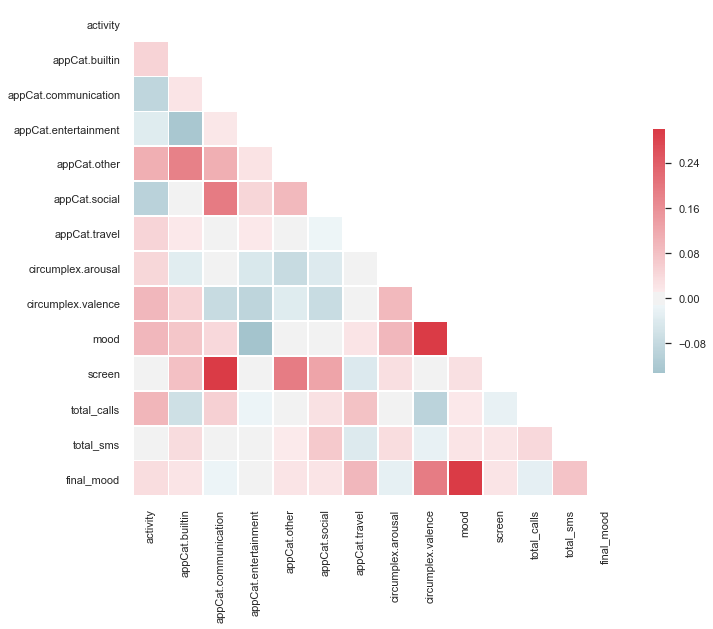

In [335]:
sns.set(style="white")

# Generate a large random dataset

# Compute the correlation matrix
corr = df_agg.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
fig = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
fig.figure.savefig("figures/correlation_heatmap.png")

## Train Models

In [4]:
import pandas as pd 
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, RobustScaler  # scale time features
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from mord import LogisticIT
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier #  OneVsRestClassifier(

In [24]:
#[i for i in range(1,11)]
# Factorizing the column data
df_agg[df_agg.columns[-1]] = df_agg[df_agg.columns[-1]].astype(int)
df_agg = df_agg[((df_agg[df_agg.columns[-1]]>5) & (df_agg[df_agg.columns[-1]]<9))] # dit in X_train
df_agg = df_agg.sort_values('final_mood')
categories = pd.Categorical(df_agg['final_mood'], categories=[i for i in range(1,11)], ordered=True)
labels, unique = pd.factorize(categories, sort=True)
df_agg['final_mood'] = labels
df_agg = df_agg.fillna(0)
# Encoded Income Range Data
df_agg['final_mood'].head()

494    0
699    0
700    0
163    0
701    0
Name: final_mood, dtype: int64

(217, 693, 259)


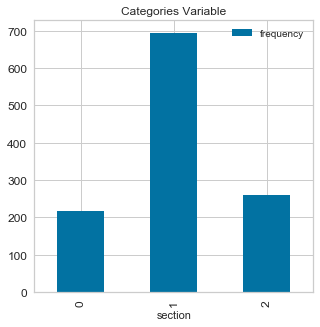

In [25]:
#df_agg[df_agg.columns[-1]].sum()
from collections import Counter

labels, values = zip(*Counter(df_agg[df_agg.columns[-1]]).items())
print(values)
df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Categories Variable", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=90)

In [26]:
print(y)

[0 1 2 ... 7 7 8]


In [109]:
import collections
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

def calculateAUC(x, y):
    """
    Calculate AUC by parts by calculating the surface area of a 
    trapzoid.

    x = x-axes 
    y = y-axes (interpolated with x)
    """
    auc = 0
    for i in range(1,len(y)):
        last_x = x[i-1]
        last_y = y[i-1]
        cur_x = x[i]
        cur_y = y[i]
        auc += np.trapz([last_y, cur_y], [last_x, cur_x])
    return auc

def sortedPredictionList(b_pred, y_test):
    """
    This function sorts the list of true labels by the
    list of predictions. The sorted list of true labels
    can be used to create a ROC-curve for a non-probability
    classifier (a.k.a. a binary classifier like decision tree).

    Input:
        b_pred = list of hard-predictions (0 or 1) 
            or probabilities (0-1)
        y_test = list of actual labels, binarized to 
            1 or 0. 

    Example for generating 'l_sorted_true':
        Before sort:
           pred: 0 1 1 0 1 0 1 0 1 1 1 0 1 0
           true: 0 1 0 0 1 0 0 1 1 0 1 0 1 1
        After sort:
           pred: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 
        -> true: 1 1 0 1 0 0 1 1 0 0 1 1 0 0

    Output:
        l_sorted_true = list of true label sorted on the 
            predictions label:
    """
    d_perf_dt = {}
    count = 0
    for i in range(0,len(y_test)):
        d_perf_dt[count] = [b_pred[count], y_test[count]]
        count += 1
    orderedDict = collections.OrderedDict(sorted(d_perf_dt.items(), key=lambda k: functi(k), reverse=True))
    l_sorted_pred= []
    l_sorted_true = []
    for x in orderedDict.items():
        l_sorted_pred.append(x[1][0])
        l_sorted_true.append(x[1][1])
    return l_sorted_true, l_sorted_pred
    
def functi(value):
    return value[1][0]

def score_binary(l_true, l_pred):
    """
    Calculates the dummy true en false positive rate for 
    a classifier that doesn't calculate probabilities 

    Input:
        l_true = list of true label sorted on the 
            predictions label.
            The function sortedPredictionList can
            be used to generate such a list!
    Output:
        TPR = list with true positive rates 
        FPR = list with false positive rates 
        PRC = list with precision (PPV)
    """
    dummi = l_true
    dummi = [2 if x==0 else x for x in dummi]
    dummi = [x -1 for x in dummi]
    l_pred.insert(0,0)
    l_true.insert(0,0)
    dummi.insert(0,0)
    # Compute basic statistics:
    TP = pd.Series(l_true).cumsum()
    FP = pd.Series(dummi).cumsum()
    P = sum(l_true)
    N = sum(dummi)
    TPR = TP.divide(P) # sensitivity / hit rate / recall
    FPR = FP.divide(N)  # fall-out
    PRC = TP.divide(TP + FP) # precision
    #d_conf = {}
    d_conf = {'tpr': TPR, 'fpr': FPR, 'prc': PRC, 'threshold': l_pred}
    return d_conf 

In [27]:
SEED =12231

clf = Pipeline([
                ('scale', StandardScaler()),
                ('clf', SVC(random_state=SEED)) #   
            ])

In [74]:
#df_agg[df_agg.columns[2:-1]][df_agg.columns[-6:-4]]

In [87]:
f1_naive = f1_score(y_valid, y_naive, average='macro')
f1_naive

0.0

In [112]:
# large folds -> to ensure enough training & validation data
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score
from yellowbrick.model_selection import RFECV
import pickle
from sklearn.metrics import make_scorer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#import warnings
#warnings.simplefilter('default',UndefinedMetricWarning)

SEED = 26062019

X = df_agg[df_agg.columns[2:-1]]
X = X.fillna(0)

y = df_agg[df_agg.columns[-1]]

targets =list(set(y))
print([str(i) for i in targets])

enc = preprocessing.LabelEncoder()
y = enc.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=SEED)

sfm = SelectFromModel(LassoCV(cv=10))
sfm.fit(X_train,y_train)

print('Before Feature Selection: ', len(X_train.columns))
X_train = sfm.transform(X_train) #.shape[1]
print('After Feature Selection: ', len(X_train[0]))

old_f1 = 0
param = 0
best_model = ''

#aucs = []

estimator_list = []
estimator = clf
param_grid =  { 
                'clf__C' : [0.0001, 0.001, 0.01, 1, 10],
                'clf__degree' : [1,2,3],
                'clf__kernel' : ['poly','linear'],
                'clf__gamma' : [0.1, 0.001, 0.0001],
                'clf__class_weight' : ['balanced', None]
            }
kfold_outer = KFold(n_splits=5,shuffle=True,random_state=SEED)

tprs, aucs = [], []
f1_list = []
fpr_scale = np.linspace(0, 1, 100)
avg_auc, acc, avg_auc_naive, acc_naive, avg_f1_score, avg_f1_score_naive = 0, 0, 0, 0, 0, 0

# For naive classifier
f1_naive = []
d_trans = {6: 0, 7: 1, 8:2}

d_f1_measures = {}

for i, (train, valid) in enumerate(kfold_outer.split(X_train, y_train)):
    
    X_tr, y_tr, X_valid, y_valid = X_train[train], y_train[train], X_train[valid], y_train[valid]
    grid = GridSearchCV(estimator, param_grid, cv=5, scoring='f1_macro')
    grid.fit(X_tr, y_tr)  # contains nan
    y_pred = grid.predict(X_valid) # grid.predict_proba
    y_naive = X_valid[:,-4].round() # take previous mood
    y_naive = [d_trans[i] if i in list(d_trans.keys()) else 3 for i in y_naive]
    #print(y_naive)

    #plotSwarm(grid, X_valid, y_valid, i)
    f1 = f1_score(y_valid, y_pred, average='macro')
    
    #er = mean_squared_error(y_valid, y_pred)
    
    print('F1:', str(f1), 'Best params:', str(grid.best_params_))  # print best hyperparam
    
    l_sorted_true, l_sorted_pred = sortedPredictionList(y_pred, y_valid)
    d_conf = score_binary(l_sorted_true, l_sorted_pred)
    tpr, fpr = d_conf['tpr'], d_conf['fpr']
    tprs.append(np.interp(fpr_scale, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = calculateAUC(fpr, tpr)
    aucs.append(roc_auc)
    avg_auc += roc_auc
    
    f1 = f1_score(y_valid, y_pred, average='macro')
    f1_list.append(f1)
    d_f1_measures['SVM'] = f1_list
    
    f1_na = f1_score(y_valid, y_naive, average='macro')
    f1_naive.append(f1_na)
    d_f1_measures['Naive'] = f1_naive
    
    avg_f1_score += f1
    
    print('AVG AUC: ', avg_auc/(i+1), 'AVG F1: ', avg_f1_score/(i+1))
    
    if f1 > old_f1:
        print('New Best')
        print('F1: ', grid.score(X_valid, y_valid))
        pickle.dump(grid, open('models/classical_model.sav', 'wb'))
        old_f1 = f1
        param = grid.best_params_
        best_model = 'SVC'
        
print('Best model:', best_model, ' MSE:', old_f1, 'Param:', param)    

['0', '1', '2']
Before Feature Selection:  13
After Feature Selection:  11
F1: 0.4720386628486317 Best params: {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__degree': 1, 'clf__gamma': 0.1, 'clf__kernel': 'linear'}
AVG AUC:  0.5230490429267188 AVG F1:  0.4720386628486317
New Best
F1:  0.4720386628486317
F1: 0.4764105447447695 Best params: {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__degree': 1, 'clf__gamma': 0.1, 'clf__kernel': 'poly'}
AVG AUC:  0.5175231100307554 AVG F1:  0.4742246037967006
New Best
F1:  0.4764105447447695
F1: 0.5683960653561163 Best params: {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__degree': 1, 'clf__gamma': 0.1, 'clf__kernel': 'poly'}
AVG AUC:  0.5249023753764068 AVG F1:  0.5056150909831726
New Best
F1:  0.5683960653561163
F1: 0.5222910818016491 Best params: {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__degree': 1, 'clf__gamma': 0.1, 'clf__kernel': 'linear'}
AVG AUC:  0.5258881988749766 AVG F1:  0.5097840886877917
F1: 0.4412405481864274

In [113]:
print(f1_list, f1_naive)

[0.4720386628486317, 0.4764105447447695, 0.5683960653561163, 0.5222910818016491, 0.44124054818642744] [0.3697102021498853, 0.3557120743034056, 0.42254739988985923, 0.4068853427895981, 0.3851909773990868]


2


<Figure size 1008x1008 with 0 Axes>

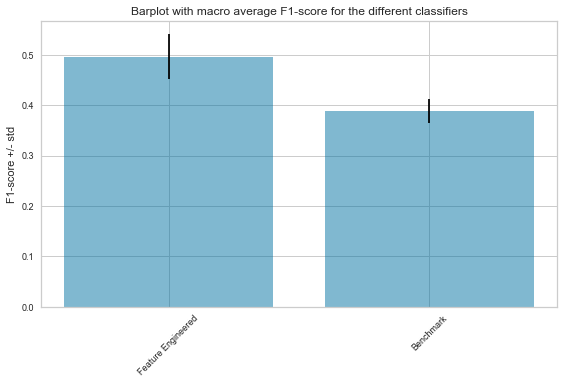

In [114]:
lbls = ['Feature Engineered', 'Benchmark']
print(len(lbls))
x_pos = np.arange(len(d_f1_measures.keys()))
l_mean = [] 
l_std = []
for key in list(d_f1_measures.keys()):
    val = np.array(d_f1_measures[key])
    l_mean.append(np.mean(val))
    l_std.append(np.std(val))

# Build the plot
plt.figure(figsize=(14,14))
fig, ax = plt.subplots()
ax.bar(x_pos, l_mean, yerr=l_std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('F1-score +/- std')
ax.set_xticks(x_pos)
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_xticklabels(lbls, rotation=45)
ax.set_title('Barplot with macro average F1-score for the different classifiers')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('figures/results/bar_plot_f1.png')
plt.show()

In [115]:
import scipy

auc_ref = d_f1_measures['Naive']

for key in d_f1_measures.keys(): # classifiers with probabilities
    twosample_results = scipy.stats.ttest_ind(d_f1_measures[key], auc_ref)
    print(key, '(p =', str(twosample_results[1]), ')')

SVM (p = 0.0027327000122630905 )
Naive (p = 1.0 )


In [146]:
y = enc.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=SEED)

In [147]:
from sklearn.metrics import accuracy_score

best_model = pickle.load(open('models/classical_model.sav', 'rb'))

print('Before Feature Selection: ', len(X_test.columns))
X_test_t = sfm.transform(X_test) #.shape[1]
print('After Feature Selection: ', len(X_test_t[0]))
y_pred =  best_model.predict(X_test_t)


f1 = f1_score(y_test, y_pred, average='macro')
print(accuracy_score(y_test, y_pred))
print('MSE final:', str(f1), 'Best params:', str(best_model.best_params_))  # print best hyperparam
print(classification_report(y_test, y_pred))

Before Feature Selection:  13
After Feature Selection:  11
0.5299145299145299
MSE final: 0.5049469403536389 Best params: {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__degree': 1, 'clf__gamma': 0.1, 'clf__kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.36      0.52      0.43        23
           1       0.71      0.51      0.60        70
           2       0.42      0.58      0.49        24

    accuracy                           0.53       117
   macro avg       0.50      0.54      0.50       117
weighted avg       0.58      0.53      0.54       117



Confusion matrix, without normalization
[[10  8  5]
 [21 35 14]
 [ 3  9 12]]


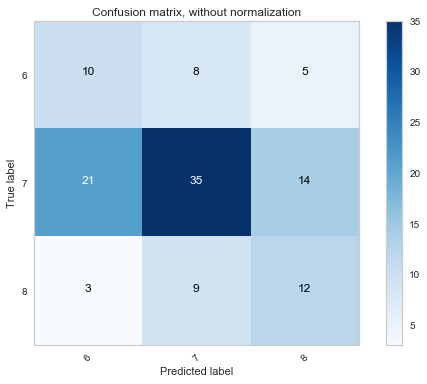

In [144]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

y_pred =  grid.predict(X_test_t)

cnf_matrix = confusion_matrix(y_test, y_pred,labels=[0,1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
ax = plt.gca()
ax.grid(False)
plot_confusion_matrix(cnf_matrix, classes=[6,7,8],
                      title='Confusion matrix, without normalization')

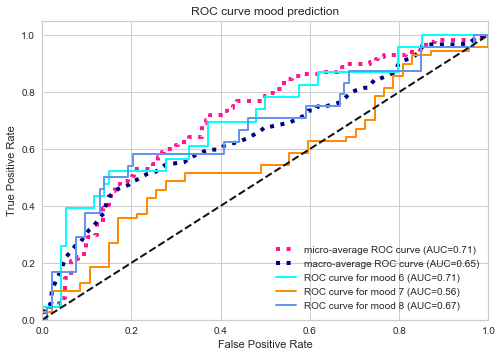

In [139]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

y_test = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test.shape[1]
lw = 2

y_score = best_model.decision_function(X_test_t)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (AUC={0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (AUC={0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve for mood {0} (AUC={1:0.2f})'
             ''.format(i+6, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve mood prediction')
plt.legend(loc="lower right")
plt.savefig("figures/results/classicalModel_ROC.png")

plt.show()


## Naive method

Confusion matrix, without normalization
[[ 7 12  3]
 [ 9 48 13]
 [ 1 11 11]]


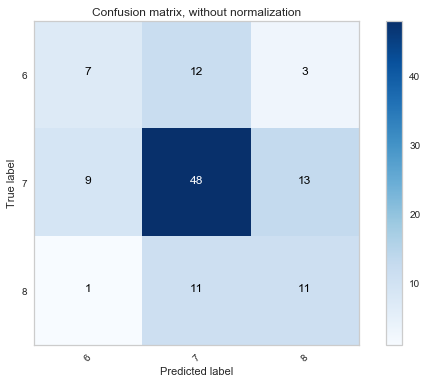

In [152]:
#y_naive_pred =  gX_test_t)
y_naive_pred = X_test_t[:,-4].round() # take previous mood
y_naive_pred = [d_trans[int(i)] if i in list(d_trans.keys()) else 3 for i in y_naive_pred]

cnf_matrix = confusion_matrix(y_test, y_naive_pred,labels=[0,1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
ax = plt.gca()
ax.grid(False)
plot_confusion_matrix(cnf_matrix, classes=[6,7,8],
                      title='Confusion matrix, without normalization')

In [154]:
y_score, y_pred

(array([[ 1.03,  1.02,  0.96],
        [ 0.96,  2.17, -0.16],
        [ 0.96,  2.19, -0.18],
        [ 1.  , -0.04,  2.05],
        [ 1.06,  2.08, -0.11],
        [ 0.94,  2.13, -0.1 ],
        [ 1.04, -0.18,  2.17],
        [-0.23,  1.11,  2.21],
        [ 1.03,  2.1 , -0.12],
        [ 0.99,  1.03,  0.98],
        [ 0.96,  2.19, -0.18],
        [-0.16,  2.2 ,  0.87],
        [ 2.06, -0.1 ,  1.05],
        [-0.05,  2.08,  0.96],
        [-0.17,  2.22,  0.85],
        [-0.23,  1.09,  2.22],
        [ 0.9 ,  2.19, -0.16],
        [-0.15,  2.21,  0.85],
        [-0.22,  1.09,  2.21],
        [ 1.12,  2.22, -0.24],
        [-0.03,  2.08,  0.93],
        [ 2.22,  1.18, -0.25],
        [ 2.22,  1.15, -0.25],
        [ 1.04,  2.13, -0.14],
        [ 1.05,  2.13, -0.15],
        [-0.08,  2.13,  0.91],
        [ 0.93, -0.16,  2.18],
        [ 0.95,  2.16, -0.15],
        [ 1.01,  2.19, -0.2 ],
        [-0.09,  2.15,  0.89],
        [ 1.05,  2.15, -0.16],
        [ 1.02,  1.03,  0.95],
        

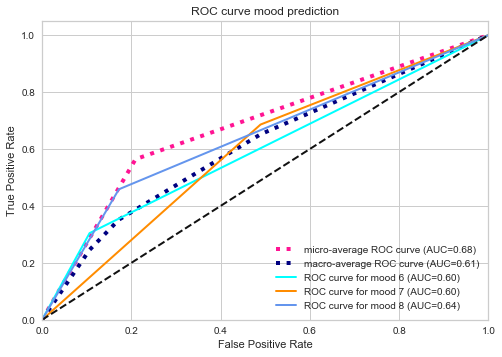

In [157]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

y_test = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test.shape[1]
lw = 2

y_score = label_binarize(y_naive_pred, classes=[0, 1, 2])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (AUC={0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (AUC={0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve for mood {0} (AUC={1:0.2f})'
             ''.format(i+6, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve mood prediction')
plt.legend(loc="lower right")
plt.savefig("figures/results/NaiveModel_ROC.png")

plt.show()

## ARIMA

In [3]:
from statsmodels.tsa.arima_model import ARIMA

df = pd.read_csv('data/prep_temporal_raw.csv', index_col=0)
df = df[~df['mood'].isna()]
df.head()

,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.other,appCat.social,appCat.travel,circumplex.arousal,circumplex.valence,mood,screen
id,,,,,,,,,,,,
AS14.01,2014-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,1.0,6.0,NaN
AS14.01,2014-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,6.0,NaN
AS14.01,2014-03-21,0.032787,4.0190,27.7435,17.061,13.6375,52.6750,19.070,0.0,0.0,6.0,32.282
AS14.01,2014-03-22,0.260593,3.8885,20.4580,46.662,10.1160,23.8730,37.305,1.0,1.0,7.0,17.252
AS14.01,2014-03-23,0.139130,3.6045,21.5770,43.178,8.5305,38.1805,NaN,0.0,1.0,7.0,20.311


In [21]:
#df['mood']

In [182]:
print(len(series[series['mood'].isna()]))
print(len(series[~series['mood'].isna()]))

31
47


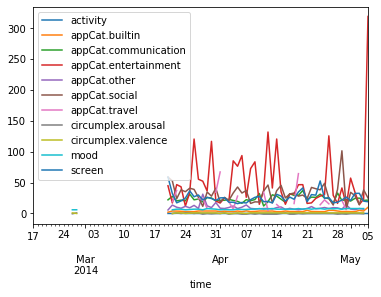

In [65]:
series.plot()
plt.show()

In [88]:
def add_freq(idx, freq=None):
    """Add a frequency attribute to idx, through inference or directly.

    Returns a copy.  If `freq` is None, it is inferred.
    """

    idx = idx.copy()
    if freq is None:
        if idx.freq is None:
            freq = pd.infer_freq(idx)
        else:
            return idx
    idx.freq = pd.tseries.frequencies.to_offset(freq)
    if idx.freq is None:
        raise AttributeError('no discernible frequency found to `idx`.  Specify'
                             ' a frequency string with `freq`.')
    return idx

In [106]:
Xs

,appCat.builtin,appCat.communication,appCat.entertainment,appCat.other,appCat.social,appCat.travel,circumplex.arousal,circumplex.valence,screen
time,,,,,,,,,
2014-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


C:\Users\levrex\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\levrex\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.mood   No. Observations:                   24
Model:                 ARIMA(5, 1, 0)   Log Likelihood                  -7.944
Method:                       css-mle   S.D. of innovations              0.262
Date:                Thu, 16 Apr 2020   AIC                             47.889
Time:                        22:09:34   BIC                             66.738
Sample:                    03-22-2014   HQIC                            52.889
                         - 05-03-2014                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.0677      0.987      3.109      0.013       1.134       5.002
appCat.builtin           0.2311      0.117      1.974      0.080       0.002       0.461
appCat.commu

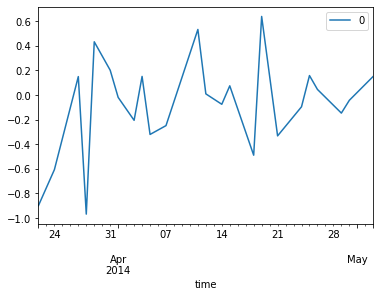

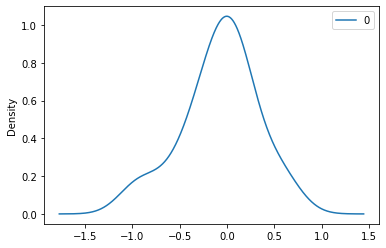

               0
count  24.000000
mean   -0.079545
std     0.394086
min    -0.967557
25%    -0.266740
50%    -0.031429
75%     0.150939
max     0.637868


In [111]:
from sklearn.preprocessing import label_binarize
from pandas import read_csv
from pandas import datetime
 
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')
 
#series = read_csv('data/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
#print(series.head())

# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
 
series = pd.read_csv('data/prep_temporal_raw.csv', parse_dates=[1], date_parser=parser) # ,  , squeeze=True header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser
series = series[series['id']=='AS14.01']

series['time'] = pd.to_datetime(series['time'].values)
tidx = pd.to_datetime(series['time'].values)
series.set_index('time', inplace=True)
series.index = pd.DatetimeIndex(series.index).to_period('d')

#tidx = pd.to_datetime(series['time'].values)
#series.plot()
#plt.show()
#pd.DatetimeIndex(tidx.values, freq = tidx.inferred_freq)

#print(yoekr)

# fit model
series = series[series['id']=='AS14.01']

#print(tidx.freq)
#print(tidx.inferred_freq)
#print(tidx)

# define X & y
l_cols = list(series.columns[2:-2])
l_cols.append('screen')
Xs= series[l_cols]


ys = series[series.columns[-2]]
#print(doke)
# 
#series = series[~series['mood'].isna()]  , dates=
model = ARIMA(endog=ys, order=(5,1,0),  exog=Xs, missing="drop") #
model_fit = model.fit(disp=0)

print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid) 
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## Training different models

In [119]:
print(len(X_train))

58


In [148]:
np.where(np.isnan(y_test))

(array([7], dtype=int64),)

In [163]:
y_train

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, 6. , 6. , nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, 6. , 7. , 7. , 6. , 6.5, 7. , 7. ,
       6. , 8. , 7.5, 7. , 6. , 6.5, 6. , 6. , 7. , 6.5, 6.5, 7. , 7. ,
       8. , 7. , 7.5, 8. , 7. , 7. , 7. , 7. , 7. , 8. , 7. , 8. , 7. ,
       8. , 8. , 7. , 8. , 7.5])

7.912041535844737 8.0
7.587958464155263 7.0
7.824083071689474 8.0
7.175916928310526 8.0
8.0 8.0
8.0 8.0
8.0 8.0
8.0 nan
predictions!
[8.0, 7.0, 8.0, 8.0, 8.0, 8.0, 8.0] [7.912041535844737, 7.587958464155263, 7.824083071689474, 7.175916928310526, 8.0, 8.0, 8.0]
Test RMSE: 0.390


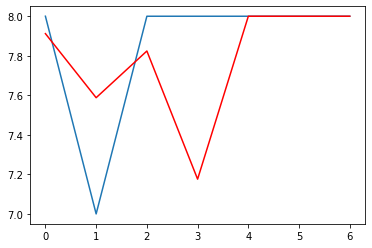

In [164]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy
 
def predict(coef, history):
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * history[-i]
    return yhat
 
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        #print(dataset[i])
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return numpy.array(diff)

size = int(len(Xs) * 0.9)
X_train, X_test = Xs[0:size].values, Xs[size:len(Xs)].values

y_train, y_test = ys[0:size].values, ys[size:len(ys)].values
history = [x for x in y_train]
predictions = list()
actual = list()
for t in range(len(X_test)):# len(X_test)
    model = ARIMA(endog=y_train, order=(1,1,0), exog=X_train, missing="drop") 
    model_fit = model.fit(disp=0)
    ar_coef, ma_coef = model_fit.arparams, model_fit.maparams
    resid = model_fit.resid
    diff = difference(history)
    # exog=X_test, exog=X_test
    
    yhat = history[-1] + predict(ar_coef, diff) + predict(ma_coef, resid)
    #print(history[-1], predict(ar_coef, diff), predict(ma_coef, resid))
    
    #output = model_fit.forecast(X_test)
    #yhat = output[0]
    #print(model_fit.predict(y_test, y_test, exog=X_test))
    
    obs = y_test[t]
    if str(obs) != 'nan' and str(yhat) != 'nan':
        predictions.append(yhat)
        actual.append(obs)
        history.append(obs)
    print(yhat, obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

print('predictions!')
print(actual, predictions)   
rmse = sqrt(mean_squared_error(actual, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
plt.plot(actual)
plt.plot(predictions, color='red')
plt.show()

### make temporal data

In [437]:
agg = Aggregation(df_mood, 'id', 'time', window=5)
agg.formatTimeSpan()
temp_df = agg.getDF()
temp_df_unstack = temp_df.groupby(['id', 'time','variable'])['value'].median().unstack('variable')
temp_df_unstack = temp_df_unstack[['activity', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.other', 'appCat.social', 'appCat.travel',
       'circumplex.arousal', 'circumplex.valence', 'mood', 'screen']]
temp_df_unstack = temp_df_unstack.reset_index(level=1, drop=False)
temp_df_unstack = temp_df_unstack.reset_index()
temp_df_unstack.to_csv(r'data/prep_temporal_raw.csv', index = False, header=True)

In [2]:
temp_df_unstack =  pd.read_csv(r'data/prep_temporal_raw.csv')
temp_df_unstack.head()

,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.other,appCat.social,appCat.travel,circumplex.arousal,circumplex.valence,mood,screen
0,AS14.01,2014-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AS14.01,2014-02-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AS14.01,2014-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AS14.01,2014-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AS14.01,2014-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
